In [1]:
import numpy as np
from numpy.random import uniform,exponential,chisquare,normal
from scipy.stats import chi2,norm,invgamma
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import arviz as az

In [ ]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2")

In [ ]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [ ]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

In [ ]:
az.plot_trace(idata, combined=True);

In [3]:
data = np.load(r'probit_data.npy')

In [ ]:
data[:,1]

In [7]:
probit_model = pm.Model()

with probit_model:
    # x = pm.ConstantData("x", data[:, 0])
    x = data[:, 0]

    # Priors for unknown model parameters
    beta = pm.Normal("beta", mu=0, sigma=10, shape=1)
    sigma = pm.InverseGamma("sigma", alpha=3/2, beta=3*1/2)
    
    p = pm.Deterministic("p", pm.math.invlogit(x*beta))

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Binomial("y", n=1, p=p, observed=data[:, 1])

In [8]:
with probit_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.


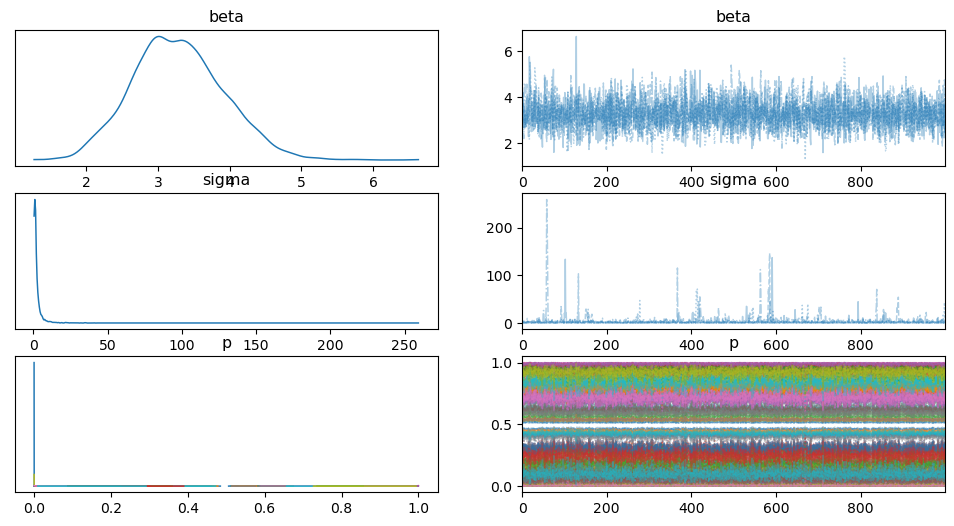

In [9]:
az.plot_trace(idata, combined=True);

In [ ]:
def posterior(beta, y, x):
    

In [10]:
data = np.load(r'mcs_hw2_p3_data.npy')

In [11]:
data

array([[-0.90763376,  0.50778836,  0.        ],
       [ 0.52653554, -1.78721255,  0.        ],
       [-0.66971187, -0.18713082,  0.        ],
       ...,
       [ 0.462534  ,  0.36492067,  1.        ],
       [ 0.95596186,  1.41754584,  1.        ],
       [-1.44815009, -0.38048994,  0.        ]])

In [15]:
data[:, :2]

array([[-0.90763376,  0.50778836],
       [ 0.52653554, -1.78721255],
       [-0.66971187, -0.18713082],
       ...,
       [ 0.462534  ,  0.36492067],
       [ 0.95596186,  1.41754584],
       [-1.44815009, -0.38048994]])

In [ ]:
data = np.load(r'mcs_hw2_p3_data.npy')
x = data[:, :2]
y = data[:, 2]

# notice the`value` here. We explain why below.
beta = pm.Normal("beta", 0, 1, value=0)

@pm.deterministic
def p(x=x, beta=beta):
    return 1.0 / (1. + np.exp(beta * t + alpha))

In [23]:
data = np.load(r'mcs_hw2_p3_data.npy')
x1 = data[:, 0]
x2 = data[:, 1]
y = data[:, 2]

with pm.Model() as binomial_regression_model:
    # priors
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    beta1 = pm.Normal("beta1", mu=0, sigma=1)
    # linear model
    mu = beta0 * x1 + beta1 * x2
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    # likelihood
    pm.Binomial("y", n=1, p=p, observed=y)

In [24]:
with binomial_regression_model:
    idata = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.


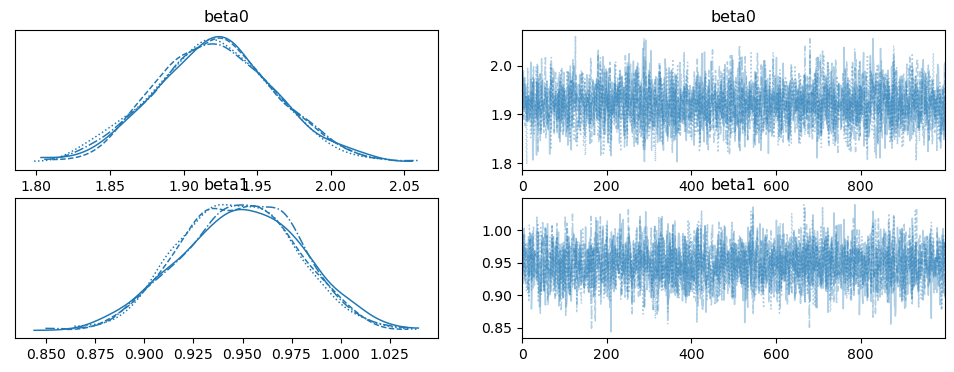

In [25]:
az.plot_trace(idata, var_names=["beta0", "beta1"]);

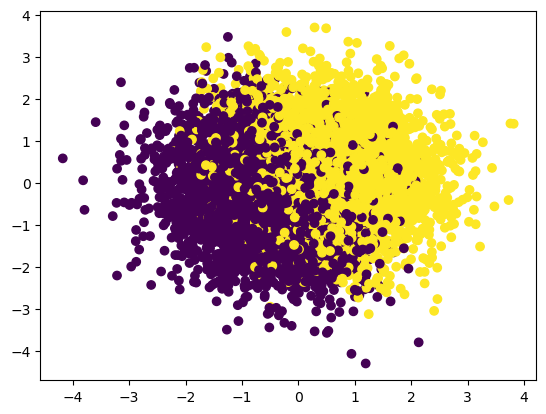

In [29]:
plt.scatter(x1, x2, c=y)

In [67]:
def U(x, y, beta):
    """
    势函数
    :param x: 位置
    :param args: 密度函数的参数
    :return: 势能
    """
    return -(y @ x @ beta - np.sum(np.log(1 + np.exp(x @ beta)), axis=0) +
             (-0.5 * beta @ beta))


def dU(beta, *args):
    """
    势函数的微分
    :param x: 位置
    :param args: 密度函数的参数
    :return: 微分
    """
    t = np.exp(x@beta)
    return -(y@x - np.sum(np.atleast_2d(t / (1+t)).T * x, axis=0)) + beta


def HMC(X, Y, initial, Lmax, step_size, fixed= True, epochs=1000):
    """
    Hamiltonian Monte Carlo
    :param initial: 初始点
    :param Lmax: 每轮次步数
    :param step_size: 步长
    :param epochs: 轮次
    :return: 样本
    """
    samples = [initial]
    for epoch in range(epochs):
        r = normal(0, 1, 2)  # 每轮epoch重新生成动量
        x = samples[-1]  # 上一次到达的位置
        # 先保存这次起点的位置
        x_prev = np.copy(x)
        r_prev = np.copy(r)
        # Simulate Hamiltonian dynamics
        if fixed:
            L = Lmax
        else:
            L = randint(1, Lmax+1)
        for step in range(L):
            # Leap-frog积分
            r = r - 0.5 * step_size * dU(x)  # 加上势函数的负梯度
            x = x + step_size * r  # 这里取的质量都是1
            r = r - 0.5 * step_size * dU(x)
        # flip the sign of the momentum
        r = -r
        # 计算接受概率
        ratio = np.exp(-(U(X, Y, x) + 0.5 * r @ r) + (U(X, Y, x_prev) + 0.5 * r_prev @ r_prev))
        accept = 1 if 1 < ratio else ratio
        u = uniform(0, 1)
        if u <= accept:
            samples.append(x)
        else:
            samples.append(x_prev)
    return samples

In [69]:
data = np.load('mcs_hw2_p3_data.npy')[:1000]
x = data[:, :2]
y = data[:, 2]

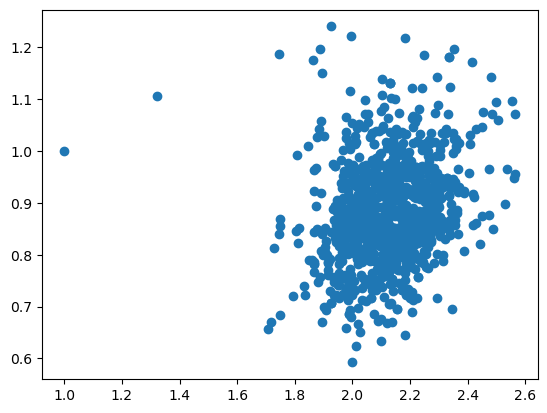

In [70]:
initial = np.array([1.0, 1.0])
trial = HMC(x, y, initial, Lmax = 10, step_size=0.1, fixed=True,epochs=1000)
trial = np.array(trial)
plt.scatter(trial[:, 0], trial[:, 1])
plt.show()